# Contornos no OpenCV

Nesta atividade, vamos explorar como encontrar os contornos de uma imagem.

Detecção de contornos é uma técnica importante em visão computacional. A ideia é que os contornos são as bordas dos objetos, e portanto, podem ser usados para detectar a localização de objetos, além de outras métricas como centro, área, perímetro, etc.

Fonte das imagens: [http://time.com/4299724/coca-cola-diet-coke-redesign/](http://time.com/4299724/coca-cola-diet-coke-redesign/)

# Componentes conexos e contornos

Neste exercicio vamos trabalhar na segunte imagem. Nosso objetivo é encontrar os contornos da parte vermelha das latinhas de coca-cola.

![image.png](img/coke-cans.jpg)


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

coke = cv2.imread("img/coke-cans.jpg")
coke_rgb= cv2.cvtColor(coke, cv2.COLOR_BGR2RGB)
coke_hsv= cv2.cvtColor(coke, cv2.COLOR_BGR2HSV)

## Filtrando o objeto

Revisando o circulo de cores HSV, temos:

![](img/hsv_circle.jfif)

Pela a imagem acima, podemos ver que o vermelho está no lado direito do circulo, em **dois** intervalos, entre 0 e 30, e entre 330 e 360.

Infelizmente, o OpenCV não permite que sejam feitas duas seleções de intervalos, ou, intervalos não contínuos (-30 : 30), o que dificulta a segmentação da cor vermelha.

Para segmentar o vermelho, podemos fazer duas seleções de intervalos, e depois somar as duas imagens binárias resultantes, da seguinte forma:

Utilizando nossa GUI para selecionar o intervalo de cores, temos:

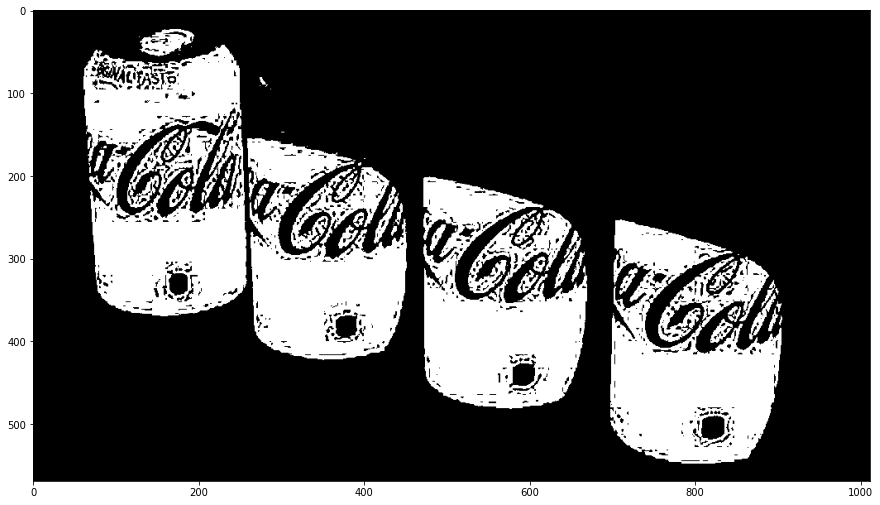

In [3]:
cor_menor1 = np.array([172, 50, 50])
cor_maior1 = np.array([180, 255, 255])
mask_coke1 = cv2.inRange(coke_hsv, cor_menor1, cor_maior1)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke1, cmap='gray')
plt.show()


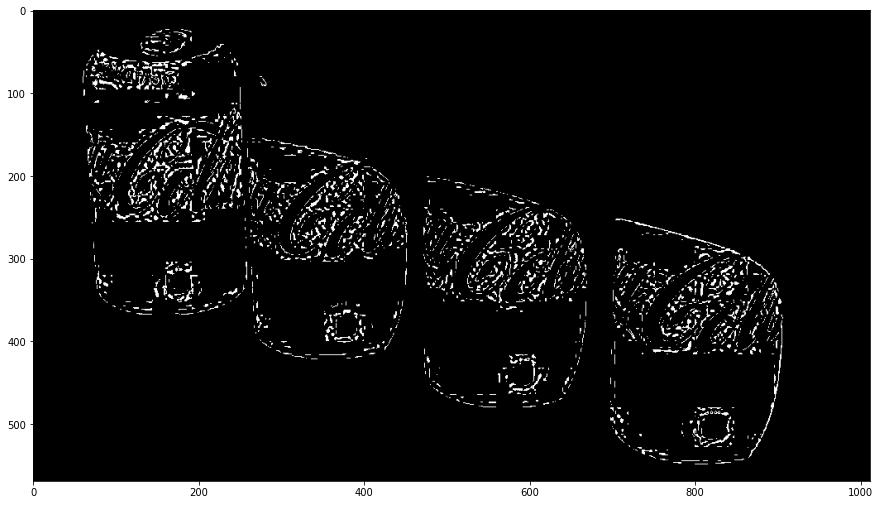

In [4]:
cor_menor2 = np.array([0, 50, 50])
cor_maior2 = np.array([8, 255, 255])
mask_coke2 = cv2.inRange(coke_hsv, cor_menor2, cor_maior2)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke2, cmap='gray')
plt.show()

Agora, podemos combinar ambas as máscaras utilizando o operador lógico OR do OpenCV. O resultado será uma imagem com os pixels que satisfazem a condição de pelo menos uma das máscaras.

In [5]:
mask_coke = cv2.bitwise_or(mask_coke1, mask_coke2)

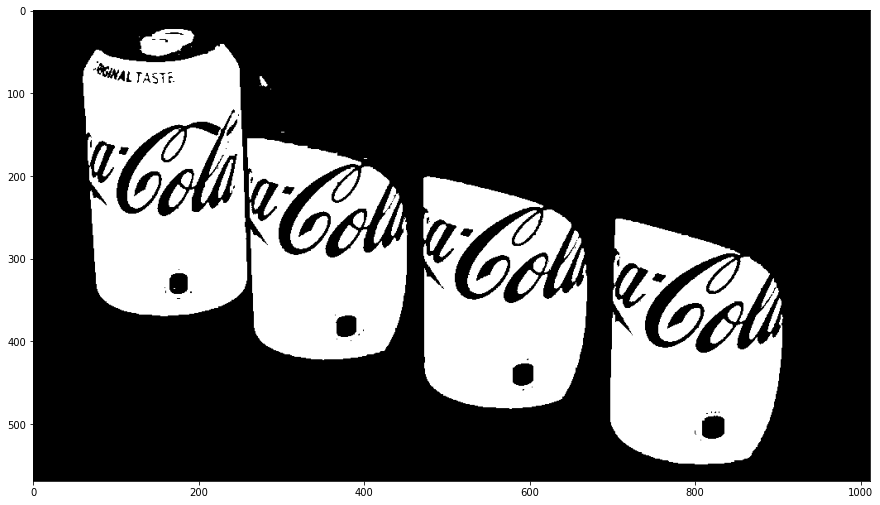

In [6]:
plt.figure(figsize=(15,10))
plt.imshow(mask_coke, cmap="gray", vmin=0, vmax=255)
plt.show()

## Componentes conexos

Após a segmentação da imagem por mascaramento, podemos observar que os pixels de interesse podem formar um ou mais grupos conectados entre si, ou seja, conjuntos de pixels que se comunicam através de algum caminho que passa apenas por pixels de interesse (brancos)

![](img/retangulos.bmp) -> ![](img/retangulos_mask.bmp) -> ![](img/retangulos_ccomp.bmp)

No OpenCV, é possível encontrar componente conexos em imagens tons de cinza através da função `cv2.findContours()`. Ela considera pixels de valor maior do que 0 como pixels de interesse. 

Usamos a função da forma:

```
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
```
onde:
- `mask` é a imagem com a máscara binária
- `cv2.RETR_CCOMP` indica que queremos organizar os contornos em componentes conexos e buracos dentro deles
- `cv2.CHAIN_APPROX_NONE` indica que queremos armazenar todos os pontos do contorno
- `contours` é uma lista de contornos, contendo os pontos a ele pertencententes
- `hierarchy` é uma lista indicando a organização dos contornos em termos dos componentes e de seus buracos


Os componentes conexos são representados através de seus contornos internos, ou seja, dos pixels de cada componente conexo que são vizinhos a pixels de fundo. Para desenhar os contornos em uma imagem, usamos a função `cv2.drawContours()`, que usamos da forma:

```
cv2.drawContours(imagem, contours, indice, cor)
```
- `imagem` é a imagem colorida ou tons de cinza a receber o contorno
- `contours` é a lista de contornos obtida com `cv2.findContours()`
- `indice` é o índice do contorno dentro da lista a ser desenhado; se indice < 0 desenha todos os contornos
- `cor` é a cor do pixel a ser usada para desenhar o contorno   



In [7]:
contornos, arvore = cv2.findContours(mask_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
len(contornos)

130

In [8]:
contornos_img = coke_rgb.copy()
cv2.drawContours(contornos_img, contornos, -1, [0, 0, 255], 3);

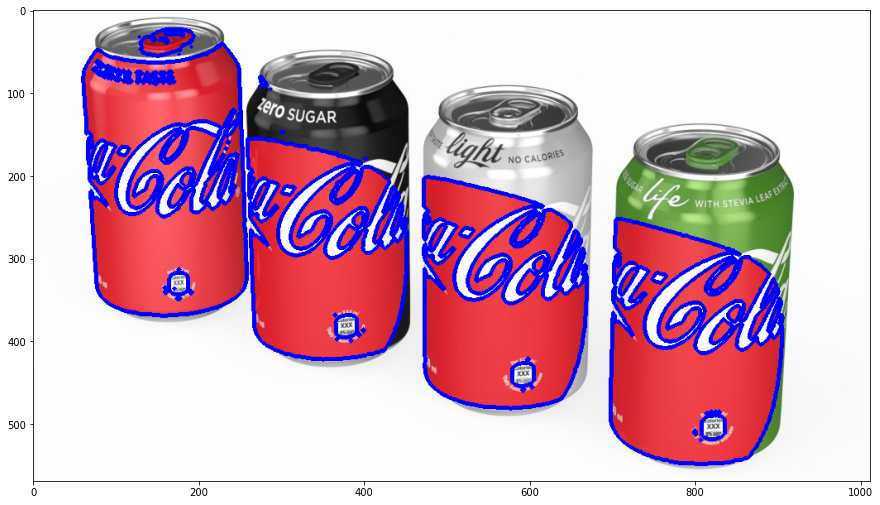

In [9]:
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

### Medidas dos contornos

A partir dos contornos, podemos tirar uma série de medidas como:
- **Área:** número de pixels pertencentes ao contorno, calculada com `cv2.contourArea(contour)`
- **Centro de massa:** linha e coluna do centro de massa do contorno
- **Caixa delimitadora:** menor retângulo que contém o contorno, calculada com `cv2.boundingRect(contour)`

#### Maior contorno
Utilizando a função `cv2.contourArea()` podemos calcular a área de cada contorno e assim encontrar o maior contorno.

Na célula abaixo, apresentamos duas formas de encontrar o maior contorno dentre os contornos encontrados na imagem.

In [10]:
import time

## Utilizando laço
start = time.perf_counter()
maior = None
maior_area = 0
for c in contornos:
    area = cv2.contourArea(c)
    if area > maior_area:
        maior_area = area
        maior = c

print(f"Tempo de execução: {time.perf_counter() - start:.5f}s")

## Utilizando max e key
start = time.perf_counter()
maior = max(contornos, key=cv2.contourArea)
print(f"Tempo de execução: {time.perf_counter() - start:.5f}s")

Tempo de execução: 0.00065s
Tempo de execução: 0.00064s


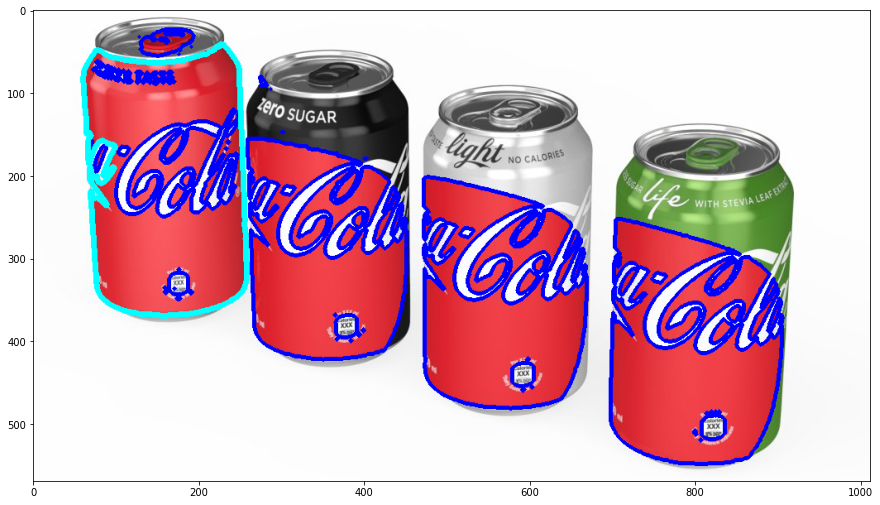

In [11]:
cv2.drawContours(contornos_img, [maior], -1, [0, 255, 255], 5)

plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

#### Centro de massa do contorno.

**Método 1** - Método mais preciso.

In [12]:
def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,5)
    cv2.line(img,(x,y - size),(x, y + size),color,5)

In [13]:
""" Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
M = cv2.moments(maior)
# Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

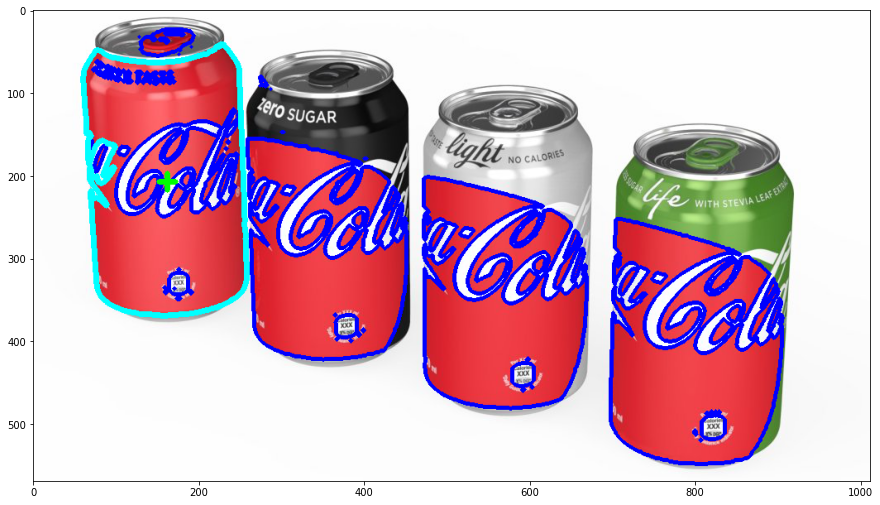

In [14]:
crosshair(contornos_img, (cX,cY), 10, (0,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

**Método 2** - Centro Geométrico

**ATENÇÃO:** essa técnica de calcular o centro de massa diretamente do contorno dá resultados melhores quando usado com contornos convexos e `cv2.CHAIN_APPROX_NONE`.
Em outros casos, é melhor fazer como no jeito 1

In [15]:
cX = int(maior[:,:,0].mean())
cY = int(maior[:,:,1].mean())

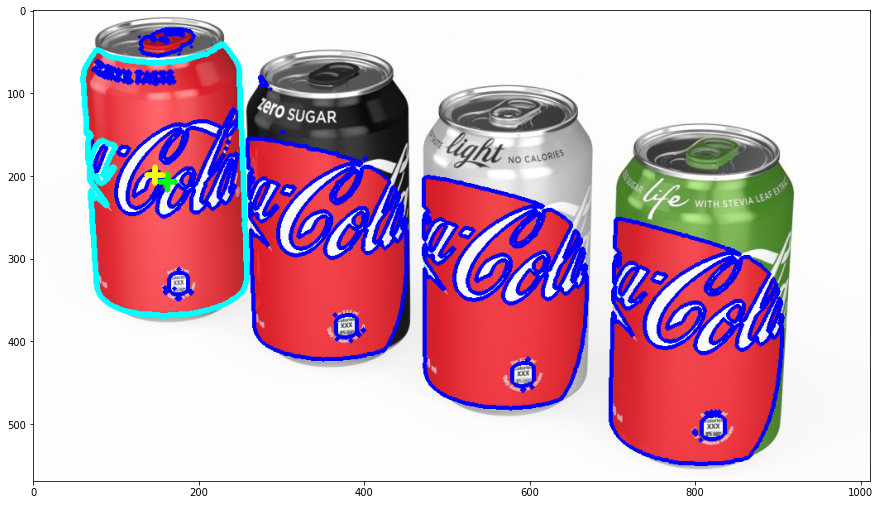

In [16]:
crosshair(contornos_img, (cX,cY), 10, (255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

#### Caixa delimitadora

Em visão computacional, uma caixa delimitadora é um retângulo que delimita as coordenadas de um objeto. A caixa delimitadora é definida pelas coordenadas de seu canto superior esquerdo e sua largura e altura.

Vamos calcular a caixa delimitadora da maior latinha de refrigerante na imagem.

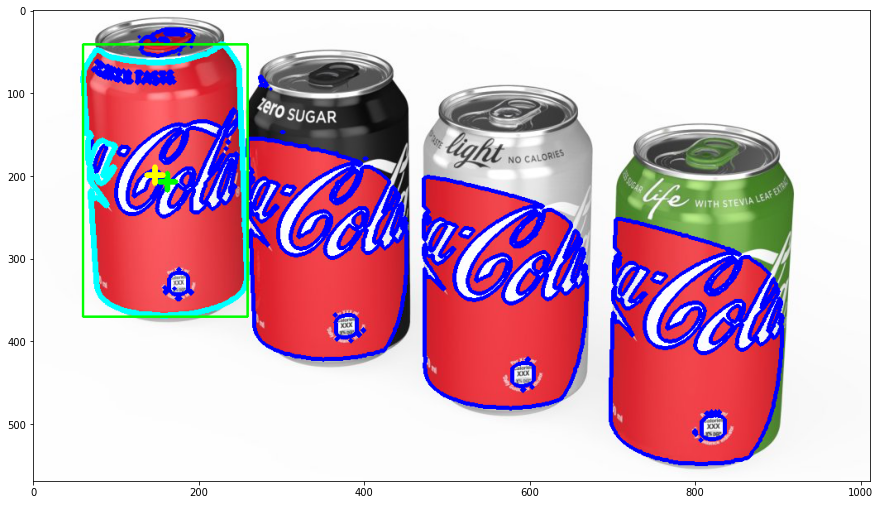

In [18]:
# get bounding rect
x, y, w, h = cv2.boundingRect(maior)

cv2.rectangle(contornos_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

# ConvexPolygon

TODO

# Implementação do módulo de visão - Parte 3

Agora estão prontos para finalizar o módulo de visão.

Nesta atividade, vocês devem implementar:

1 - A função encontrar os contornos de uma imagem na função `find_contours`;

2 - Uma função para ordenar os contornos da imagem na função `sort_contours`;

3 - Funções para calcular o centro, a área e a caixa delimitadora de um contorno respectivamente nas função `contour_center`, `contour_area` e `bounding_box`;

4 - Funções para desenhar os contornos e a caixa delimitadora de um contorno respectivamente nas funções `draw_contours` e `draw_bounding_box`.

E então, utilize o módulo de visão para resolver os seguintes problemas:

# Prática

**Exercício 1**: ainda trabalhando com as imagens das latinhas, use seus conhecimentos de segmentação de imagens para obter uma máscara que tenha somente o contorno externo das 4 latinhas.

**Dica:** Pode utilizar a função `sorted´ para ordenar os contornos por área.

**Exercício 2**: usando código, faça uma função que filtra a máscara anterior e deixa somente as latinhas da Coca-cola Life (a que tem a parte verde no topo).

**Dica**: use as funções de contornos para analisar cada latinha individualmente. Depois disso, veja se a latinha contém uma quantidade de pixels verdes "grande".

**Exercício 3:** Abra a imagem `pingpong.jpg` e desenhe o centro de massa e a caixa delimitadora da bolinha laranja. Imprima também a sua área na tela.

<div id="hough"></div>